# A Reliable Energy Consumption Analysis System for Energy-Efficient Appliances

## Importing Packages

In [8]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn import metrics 
from sklearn.model_selection import cross_val_score
import pickle
from flask import Flask,request,render_template

## importing Dataset

In [9]:
dt = pd.read_csv('/content/drive/MyDrive/household_power_consumption.txt',sep = ';',
                parse_dates={'dt':['Date','Time']},
                infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'],
                index_col='dt')

In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [11]:
dt.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
dt.replace('?',np.nan,inplace=True)

In [13]:
dt.loc[dt.Sub_metering_3.isnull()].head

<bound method NDFrame.head of                      Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-21 11:23:00                  NaN                    NaN      NaN   
2006-12-21 11:24:00                  NaN                    NaN      NaN   
2006-12-30 10:08:00                  NaN                    NaN      NaN   
2006-12-30 10:09:00                  NaN                    NaN      NaN   
2007-01-14 18:36:00                  NaN                    NaN      NaN   
...                                  ...                    ...      ...   
2010-09-28 19:09:00                  NaN                    NaN      NaN   
2010-09-28 19:10:00                  NaN                    NaN      NaN   
2010-09-28 19:11:00                  NaN                    NaN      NaN   
2010-09-28 19:12:00                  NaN                    NaN      NaN   
2010-10-24 15:35:00                  NaN                  

In [14]:
dt = dt.dropna(how = 'all')

In [15]:
for i in dt.columns:
  dt[i] = dt[i].astype("float64")

In [16]:
values = dt.values
dt['Sub_metering_4'] = (values[:,0]*1000/60)-(values[:,4]+ values[:,5]+values[:,6])
dt.shape

(2049280, 8)

In [17]:
dt.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Sub_metering_4           float64
dtype: object

In [18]:
dt.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555,0.701380
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617,0.211624
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172,-0.271371
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543,0.703258
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571,0.125067
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872,0.085201
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000,0.178724
Sub_metering_4,0.701380,0.211624,-0.271371,0.703258,0.125067,0.085201,0.178724,1.000000


In [19]:
dt.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.314693e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.585916e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


## Uni-Variate

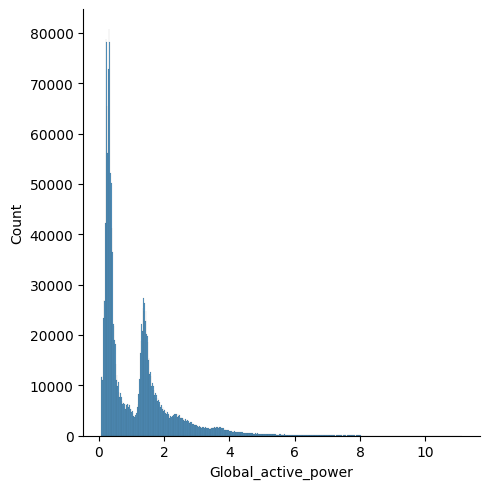

In [20]:
sns.displot(dt['Global_active_power'])

<ipython-input-21-7559161a8b98>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dt['Global_reactive_power'],kde=False,bins=30)


<Axes: xlabel='Global_reactive_power'>

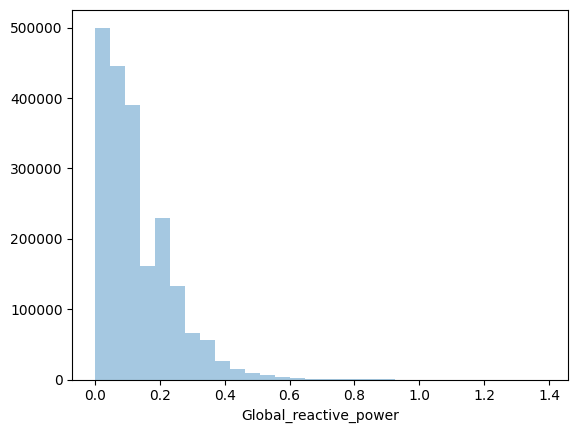

In [21]:
sns.distplot(dt['Global_reactive_power'],kde=False,bins=30)

<ipython-input-22-9d23c0ca6d45>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dt['Global_active_power'],kde=False,bins=30)


<Axes: xlabel='Global_active_power'>

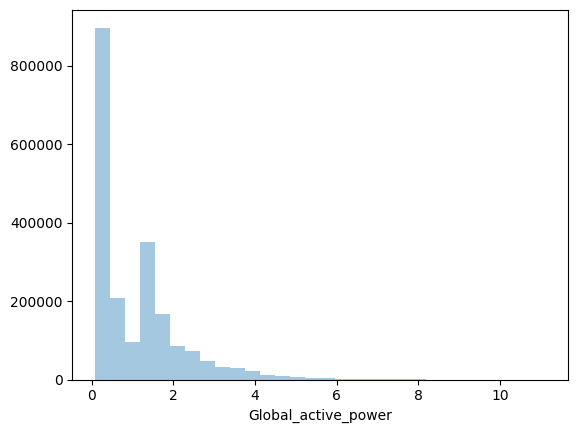

In [22]:
sns.distplot(dt['Global_active_power'],kde=False,bins=30)

## Bivariate Analysis

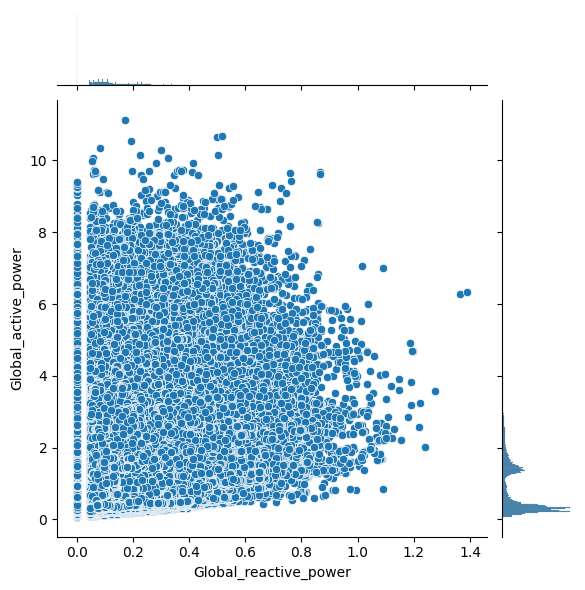

In [23]:
sns.jointplot(x = 'Global_reactive_power',y = 'Global_active_power',data = dt,kind = 'scatter')

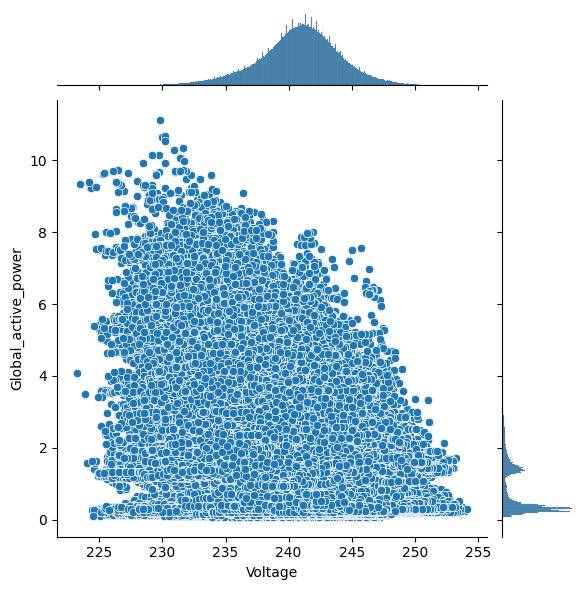

In [24]:
sns.jointplot(x = 'Voltage',y = 'Global_active_power',data = dt,kind = 'scatter')

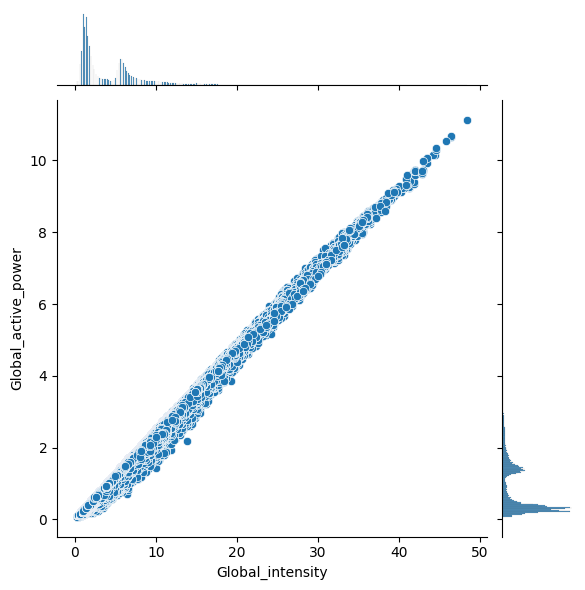

In [25]:
sns.jointplot(x = 'Global_intensity',y = 'Global_active_power',data = dt,kind = 'scatter')

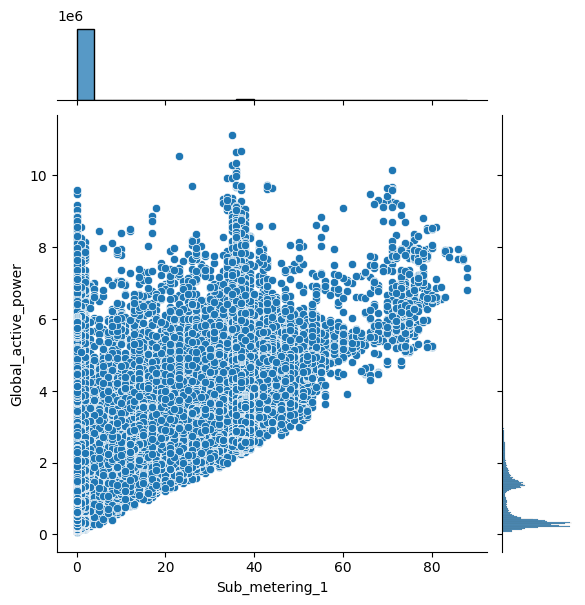

In [26]:
sns.jointplot(x = 'Sub_metering_1',y = 'Global_active_power',data = dt,kind = 'scatter')

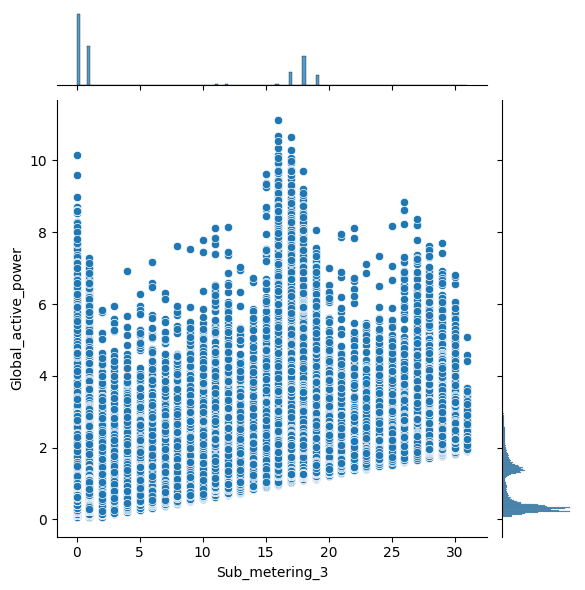

In [27]:
sns.jointplot(x = 'Sub_metering_3',y = 'Global_active_power',data = dt,kind = 'scatter')

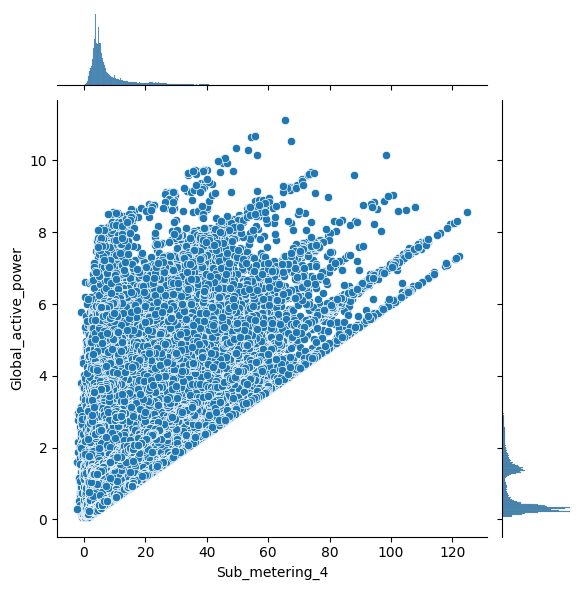

In [28]:
sns.jointplot(x = 'Sub_metering_4',y = 'Global_active_power',data = dt,kind = 'scatter')

## Multivariate analysis

<Axes: >

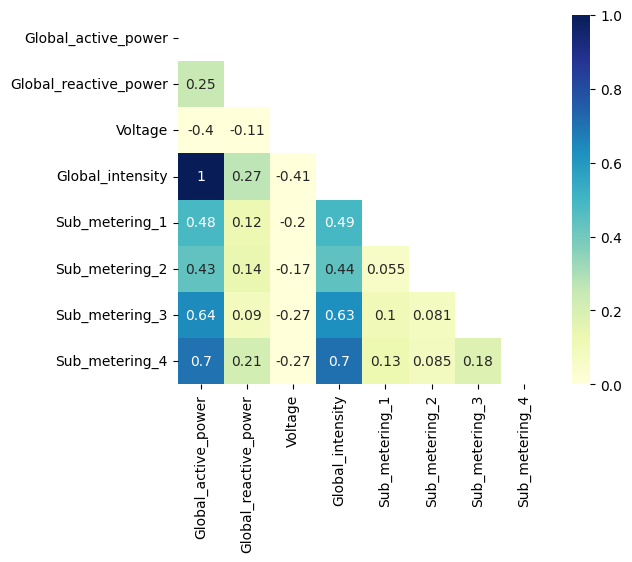

In [29]:
pearson = dt.corr(method='pearson')
mask = np.zeros_like(pearson)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pearson, vmax=1,vmin=0,square=True,cbar=True,annot=True,cmap="YlGnBu",mask=mask)

In [30]:
X = dt.iloc[:,[1,3,4,5,6]]
y = dt.iloc[:,0]
X.head()

,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,
2006-12-16 17:24:00,0.418,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,0.436,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,0.498,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,0.502,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,0.528,15.8,0.0,1.0,17.0


In [31]:
y.head()

dt
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

## Splitting train and test Dataset

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1434496, 5)
(614784, 5)
(1434496,)
(614784,)


## Training The Model In Multiple Algorithms 

### Linear Regression model

In [34]:
lm=LinearRegression()
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)

In [35]:
predictions

array([1.5456171 , 0.38372881, 0.66394625, ..., 2.56795647, 0.35617747,
       0.14704162])

### XGB Regressor



In [36]:
import xgboost as xgb
model2 = xgb.XGBRegressor()
model2.fit(X_train,y_train)
y_predict2 = model2.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
y_predict2

### Random Forest Regressor Model

In [ ]:
model3 = RandomForestRegressor()
model3.fit(X_train,y_train)
y_predict3 = model3.predict(X_test)

In [ ]:
y_predict3

### Ridge Regressor Model



In [ ]:
model4 = Ridge()
model4.fit(X_train, y_train)
y_pred_ridge = model4.predict(X_test)

In [ ]:
y_pred_ridge

## Prediction

LINEAR

In [37]:
y_p1 = lm.predict([[0.148,18.4,0.0,1.0,17.0]])
y_p1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([4.37014654])

Random Forest Regressor Model

In [ ]:
y_p3 = model3.predict([[0.148,18.4,0.0,1.0,17.0]])
y_p3

In [ ]:
y_p4 = model4.predict([[0.148,18.4,0.0,1.0,17.0]])
y_p4

## Testing Model With Multiple Evaluation Metrics

LINEAR

In [38]:
print('MAE:' ,metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:' ,np.sqrt(metrics.mean_squared_error(y_test,predictions)))
print('RSquarevalue:' ,metrics.r2_score (y_test,predictions))

MAE: 0.027436181632289502
MSE: 0.0018080813899058466
RMSE: 0.042521540304954225
RSquarevalue: 0.9983866044361693


XGB Regressor


In [ ]:
print('MAE:' ,metrics.mean_absolute_error(y_test,y_predict2))
print('MSE:',metrics.mean_squared_error(y_test,y_predict2))
print('RMSE:' ,np.sqrt(metrics.mean_squared_error(y_test,y_predict2)))
print('RSquarevalue:' ,metrics.r2_score (y_test,y_predict2))

Random Forest Regressor Model

In [ ]:
print('MAE:' ,metrics.mean_absolute_error(y_test,y_predict3))
print('MSE:',metrics.mean_squared_error(y_test,y_predict3))
print('RMSE:' ,np.sqrt(metrics.mean_squared_error(y_test,y_predict3)))
print('RSquarevalue:' ,metrics.r2_score (y_test,y_predict3))

Ridge model

In [ ]:
print('MAE:' ,metrics.mean_absolute_error(y_test,y_pred_ridge))
print('MSE:',metrics.mean_squared_error(y_test,y_pred_ridge))
print('RMSE:' ,np.sqrt(metrics.mean_squared_error(y_test,y_pred_ridge)))
print('RSquarevalue:' ,metrics.r2_score (y_test,y_pred_ridge))

## Comparing Model Accuracy Before & After Applying Hyperparameter Tuning

In [39]:
cv = cross_val_score(lm,X,y,cv=5)

In [40]:
np.mean(cv)

0.9983016109615026

## Save The Best Model


In [41]:
filename = 'PCASSS_model.pkl'
pickle.dump(lm,open(filename,'wb'))

## Integrate With Web Framework


In [42]:
model = pickle.load(open('PCASSS_model.pkl','rb'))
app = Flask(__name__)

In [43]:
@app.route("/")
def f():
  return render_template("index.html")

@app.route("/inspect")
def inspect():
  return render_template("inspect.html")

In [44]:
@app.route("/home", methods=["GET", "POST" ])
def home():
  GlobalReactivePower = float(request.form['GlobalReactivePower'])
  Global_intensity - float(request.form['Global_intensity'])
  Sub_metering_1 - float(request.form['Sub_metering_1'])
  Sub_metering_2 - float(request.form['Sub_metering_2'])
  Sub_metering_3 = float(request.form['Sub_metering_3'])
  X = [[GlobalReactivePower,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3]]
  output = round(model.predict (X) [0], 3)
  return render_template('output .htmI',output=output)

In [ ]:
if __name__ == "__main__":
  app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
